# Imports and functions

In [0]:
import requests
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Request df

In [0]:
url = 'https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json'

try:
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    data = response.json()
    # print(data)
except requests.exceptions.HTTPError as err:
    print(f"Erro HTTP: {err}")
except requests.exceptions.RequestException as err:
    print(f"Erro na requisição: {err}")
except ValueError:
    print("Resposta não era um JSON válido")

# Tratamento Json

In [0]:
col_names = [col['name'] for col in data['meta']['view']['columns']]

dict_nomes_cols = dict(enumerate(col_names))

print(dict_nomes_cols)

{0: 'sid', 1: 'id', 2: 'position', 3: 'created_at', 4: 'created_meta', 5: 'updated_at', 6: 'updated_meta', 7: 'meta', 8: 'Year', 9: 'First Name', 10: 'County', 11: 'Sex', 12: 'Count'}


In [0]:
df = spark.createDataFrame([data])

df_data = (
    df
    .select('data')
)

df.printSchema()

root
 |-- data: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- meta: map (nullable = true)
 |    |-- key: string
 |    |-- value: map (valueContainsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)



In [0]:
df_exploded = (
    df_data
    .select(F.posexplode("data").alias("indice_pai", "inner_array"))
    .select("indice_pai", F.posexplode("inner_array").alias("indice_filho", "data"))
)

df_exploded.show(15)

+----------+------------+--------------------+
|indice_pai|indice_filho|                data|
+----------+------------+--------------------+
|         0|           0|  row-ddjv_cm93_6icc|
|         0|           1|00000000-0000-000...|
|         0|           2|                   0|
|         0|           3|          1745607798|
|         0|           4|                null|
|         0|           5|          1745607798|
|         0|           6|                null|
|         0|           7|                 { }|
|         0|           8|                2022|
|         0|           9|              OLIVIA|
|         0|          10|              Albany|
|         0|          11|                   F|
|         0|          12|                  16|
|         1|           0|  row-dbx8_dtbn-e5i4|
|         1|           1|00000000-0000-000...|
+----------+------------+--------------------+
only showing top 15 rows



In [0]:
df_pivot= (
    df_exploded
    .groupBy("indice_pai")
    .pivot("indice_filho")
    .agg(F.first("data"))
)

df_pivot.show(15)

+----------+------------------+--------------------+---+----------+----+----------+----+---+----+--------+--------+---+---+
|indice_pai|                 0|                   1|  2|         3|   4|         5|   6|  7|   8|       9|      10| 11| 12|
+----------+------------------+--------------------+---+----------+----+----------+----+---+----+--------+--------+---+---+
|        12|row-bfwz.2ug8~y4p4|00000000-0000-000...|  0|1745607798|null|1745607798|null|{ }|2022|    MAYA|  Albany|  F|  7|
|        26|row-ei46_nc7y-vusw|00000000-0000-000...|  0|1745607798|null|1745607798|null|{ }|2022|   SOFIA|  Albany|  F|  5|
|        27|row-ez5j~v84v.ibgq|00000000-0000-000...|  0|1745607798|null|1745607798|null|{ }|2022|   EMILY|  Albany|  F|  5|
|        28|row-pcu2~c7c3~hh29|00000000-0000-000...|  0|1745607798|null|1745607798|null|{ }|2022| ABIGAIL|  Albany|  F|  5|
|        31|row-a3qe~ftif-35v8|00000000-0000-000...|  0|1745607798|null|1745607798|null|{ }|2022|   MAEVE|  Albany|  F|  5|
|       

In [0]:
df_final = (
    df_pivot
    .select(
        *[
            F.col(str(pos)).alias(dict_nomes_cols.get(pos, f"col_{pos}"))
            for pos in sorted(dict_nomes_cols)
        ]
    )
)

# Tratamento de dados

In [0]:
df_final_tratado = (
    df_final
    .withColumn("ts", F.from_unixtime(F.col("created_at")).cast("timestamp"))
    .withColumn("created_at", F.date_format(F.col("ts"), "dd/MM/yyyy"))
    .withColumn("ts2", F.from_unixtime(F.col("updated_at")).cast("timestamp"))
    .withColumn("updated_at", F.date_format(F.col("ts2"), "dd/MM/yyyy"))
    .withColumn("Year", F.year(F.col("Year")))
    .drop('ts', 'ts2', 'ano_int')
)

In [0]:
df_birth_infos = (
    df_final_tratado
    .select('sid', 'id', 'Year', 'First Name', 'County', 'Sex', 'Count', 'created_at', 'updated_at')
    .orderBy('created_at', 'updated_at')
)
df_birth_infos.display()

sid,id,Year,First Name,County,Sex,Count,created_at,updated_at
row-vtb8_j2vg-fhgx,00000000-0000-0000-AADD-85B141D06470,2022,LUNA,Albany,F,7,25/04/2025,25/04/2025
row-ddjv_cm93_6icc,00000000-0000-0000-0E58-7483520AF138,2022,OLIVIA,Albany,F,16,25/04/2025,25/04/2025
row-bfwz.2ug8~y4p4,00000000-0000-0000-27D4-CEC58D74A4EC,2022,MAYA,Albany,F,7,25/04/2025,25/04/2025
row-7bm2-ibrt_zigs,00000000-0000-0000-3BE2-1DBFC1A5B82A,2022,AVERY,Albany,F,12,25/04/2025,25/04/2025
row-dbx8_dtbn-e5i4,00000000-0000-0000-CE32-1B645DB021DD,2022,AMELIA,Albany,F,15,25/04/2025,25/04/2025
row-bj6j.xn72-6tuj,00000000-0000-0000-295A-436D77B2237D,2022,AURORA,Albany,F,7,25/04/2025,25/04/2025
row-ei46_nc7y-vusw,00000000-0000-0000-DE3E-D78A2680C322,2022,SOFIA,Albany,F,5,25/04/2025,25/04/2025
row-ktni.s7mw-ses5,00000000-0000-0000-28B5-40B9184568AB,2022,WILLOW,Albany,F,7,25/04/2025,25/04/2025
row-6r8n-upkk_tqbr,00000000-0000-0000-6D85-4FD50528B29D,2022,VIOLET,Albany,F,6,25/04/2025,25/04/2025
row-uzqx~g3h4~nzdr,00000000-0000-0000-B5FF-9D3B803238A2,2022,AVA,Albany,F,6,25/04/2025,25/04/2025


# Visualizações

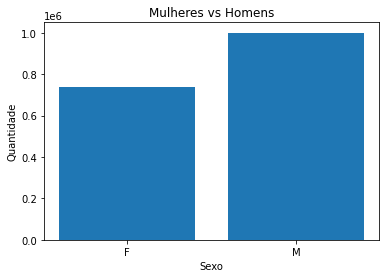

In [0]:
values = (
    df_birth_infos
      .groupBy("Sex")
      .agg(F.sum(F.col("count")).alias("total"))
      .collect()
)

dict_values = { row["Sex"]: row["total"] for row in values }

labels = ["F", "M"]
totals = [ dict_values.get(sex, 0) for sex in labels ]

plt.figure()
plt.bar(labels, totals)
plt.xlabel("Sexo")
plt.ylabel("Quantidade")
plt.title("Mulheres vs Homens")
plt.show()


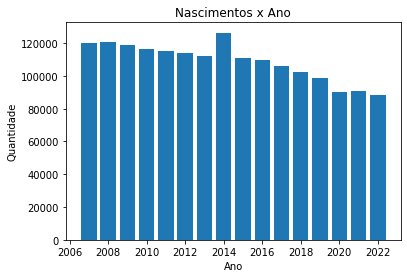

In [0]:
values = (
    df_birth_infos
      .groupBy("Year")
      .agg(F.sum(F.col("count")).alias("total"))
      .collect()
)

dict_values = { row["Year"]: row["total"] for row in values }

labels = [row['Year'] for row in df_birth_infos.select(f.col('Year')).distinct().collect()]
totals = [dict_values[year] for year in labels]


plt.figure()
plt.bar(labels, totals)
plt.xlabel("Ano")
plt.ylabel("Quantidade")
plt.title("Nascimentos x Ano")
plt.show()

# Export

In [0]:
df_birth_infos.createOrReplaceTempView("birth_infos")
